In [ ]:
import os
import re
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import (
    DataLoader,
    Dataset
)
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.transformer import MaxViT
from skimage.metrics import structural_similarity as ssim

In [ ]:
def extract_frames(
    video_path: str,
    output_folder: str,
    frame_rate: int=1,
    skip_frames: bool=False
    ) -> list:
        """
            Extracts frames from a video file and saves them as images.

            This function reads a video from `video_path`, extracts frames at the specified `frame_rate`, and saves them to `output_folder`.
            It can optionally skip frames based on the `skip_frames` flag.

            Arguments:
                video_path (str): Path to the input video file.
                output_folder (str): Directory where the extracted frames will be saved.
                frame_rate (int, optional): Number of frames to extract per second. Defaults to 1.
                skip_frames (bool, optional): If True, skips frames based on the frame rate. Defaults to False.

            Returns:
                list: A list of filenames for the extracted frames.
        """    
        if not os.path.exists(output_folder):
            os.makedirs(name=output_folder)
        cap=cv2.VideoCapture(filename=video_path)
        fps=int(cap.get(propId=cv2.CAP_PROP_FPS))
        frame_names=[]
        frame_count=0
        while cap.isOpened():
            ret, frame=cap.read()
            if not ret:
                break
            if skip_frames:
                if frame_count%(fps//frame_rate)==0:
                    video_name=re.search(
                        pattern="v_[^\\/]+(?=\\.)",
                        string=video_path
                    ).group(0)
                    frame_name=f"{video_name}_frame_{frame_count}.jpg"
                    frame_path=os.path.join(output_folder, frame_name)
                    cv2.imwrite(
                        filename=frame_path,
                        img=frame
                    )
                    frame_names.append(frame_name)
                    frame_count+=1
            else:
                video_name=re.search(
                    pattern="v_[^\\/]+(?=\\.)",
                    string=video_path
                ).group(0)
                frame_name=f"{video_name}_frame_{frame_count}.jpg"
                frame_path=os.path.join(output_folder, frame_name)
                cv2.imwrite(
                    filename=frame_path,
                    img=frame
                )
                frame_names.append(frame_name)
                frame_count+=1
        cap.release()
        return frame_names

In [ ]:
def preprocess_frame(
    image_path: str,
    target_size: tuple=(64, 64)
) -> np.ndarray:
    """
    Preprocesses an image by resizing and normalizing it.

    This function opens an image from `image_path`, resizes it to `target_size`, and normalizes the pixel values to the range [0, 1].

    Arguments:
        image_path (str): Path to the input image file.
        target_size (tuple, optional): Desired size for the output image as (width, height). Defaults to (64, 64).

    Returns:
        np.ndarray: The preprocessed image as a NumPy array with normalized pixel values.
    """
    image=Image.open(fp=image_path).resize(size=target_size)
    image_array=np.array(object=image)/255.0
    return image_array

In [5]:
input_folders=[r"app/data/videos/BreastStroke", r"app/data/videos/Kayaking", r"app/data/videos/Rafting", r"app/data/videos/Rowing", r"app/data/videos/Surfing"]
frame_folder=r"app/data/frames"
video_files=[]
for input_folder in input_folders:
    video_files.extend(
        os.listdir(input_folder)
    )
video_paths=[]
for input_folder in input_folders:
    video_files=os.listdir(input_folder)
    video_paths.extend([
        os.path.join(input_folder, video_file)
        for video_file in video_files
    ])
dataframe=pd.DataFrame(columns=["video_file", "frame_file"])
for video_path in tqdm(
    iterable=video_paths,
    desc="Extracting Frames",
    unit="video"
):
    video_file=os.path.basename(p=video_path)
    frame_paths=extract_frames(
        video_path=video_path,
        output_folder=frame_folder
    )
    for frame_path in frame_paths:
        dataframe=pd.concat(
            objs=[dataframe, pd.DataFrame(
                    data=[[video_file, frame_path]],
                    columns=["video_file", "frame_file"]
                )
            ],
            ignore_index=True
        )
dataframe["label"]=dataframe["video_file"].apply(lambda x: x.split("_")[1])
dataframe

Extracting Frames: 100%|██████████| 459/459 [02:51<00:00,  2.68video/s]


,video_file,frame_file,label
0,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_4.jpg,BreastStroke
...,...,...,...
102098,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_187.jpg,Surfing
102099,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_188.jpg,Surfing
102100,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_189.jpg,Surfing
102101,v_Surfing_g08_c01.avi,v_Surfing_g08_c01_frame_190.jpg,Surfing


In [6]:
sample_dataframe=dataframe.groupby(
    by="label",
    group_keys=False
).apply(lambda x: x[x["video_file"].isin(x["video_file"].unique()[:50])]).reset_index(drop=True)
sample_dataframe

<ipython-input-6-5c6b06ff0b8b>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ).apply(lambda x: x[x["video_file"].isin(x["video_file"].unique()[:50])]).reset_index(drop=True)


,video_file,frame_file,label
0,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_0.jpg,BreastStroke
1,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_1.jpg,BreastStroke
2,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_2.jpg,BreastStroke
3,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_3.jpg,BreastStroke
4,v_BreastStroke_g07_c03.avi,v_BreastStroke_g07_c03_frame_4.jpg,BreastStroke
...,...,...,...
53733,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_145.jpg,Surfing
53734,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_146.jpg,Surfing
53735,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_147.jpg,Surfing
53736,v_Surfing_g11_c03.avi,v_Surfing_g11_c03_frame_148.jpg,Surfing


In [ ]:
def filter_dataframe(
    video_files: pd.DataFrame,
    dataframe: pd.DataFrame
) -> pd.DataFrame:
    """
    Filters a dataframe to include only rows with specified video files.

    This function returns a subset of `dataframe` where the "video_file" column values are present in the `video_files` dataframe.

    Arguments:
        video_files (pd.DataFrame): DataFrame containing the video files to filter by, with a "video_file" column.
        dataframe (pd.DataFrame): The original dataframe to be filtered, containing a "video_file" column.

    Returns:
        pd.DataFrame: A filtered dataframe containing only the rows with video files present in `video_files`.
    """
    return dataframe[dataframe["video_file"].isin(values=video_files["video_file"])]

In [8]:
video_file_labels=sample_dataframe[["video_file", "label"]].drop_duplicates()
train_files, temporary_files=train_test_split(
    video_file_labels,
    test_size=0.2,
    stratify=video_file_labels["label"],
    random_state=42
)
validation_files, test_files=train_test_split(
    temporary_files,
    test_size=0.5,
    stratify=temporary_files["label"],
    random_state=42
)
train_set=filter_dataframe(
    video_files=train_files,
    dataframe=sample_dataframe
)
validation_set=filter_dataframe(
    video_files=validation_files,
    dataframe=sample_dataframe
)
test_set=filter_dataframe(
    video_files=test_files,
    dataframe=sample_dataframe
)
train_set=train_set.reset_index(drop=True)
validation_set=validation_set.reset_index(drop=True)
test_set=test_set.reset_index(drop=True)
tqdm.pandas()
train_set["prepared_frame"]=train_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
validation_set["prepared_frame"]=validation_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
test_set["prepared_frame"]=test_set["frame_file"].progress_apply(lambda x: preprocess_frame(image_path=os.path.join(frame_folder, x)))
print("Training Set:", train_set["label"].value_counts())
print("Validation Set:", validation_set["label"].value_counts())
print("Test Set:", test_set["label"].value_counts())

100%|██████████| 4900/4900 [00:07<00:00, 652.44it/s]

Training Set: label
Rowing          12418
Surfing          8375
Kayaking         7637
BreastStroke     7566
Rafting          7422
Name: count, dtype: int64
Validation Set: label
Rowing          1572
Surfing         1272
Rafting         1086
Kayaking         918
BreastStroke     572
Name: count, dtype: int64
Test Set: label
Rowing          1232
Surfing         1138
Rafting         1115
Kayaking         854
BreastStroke     561
Name: count, dtype: int64


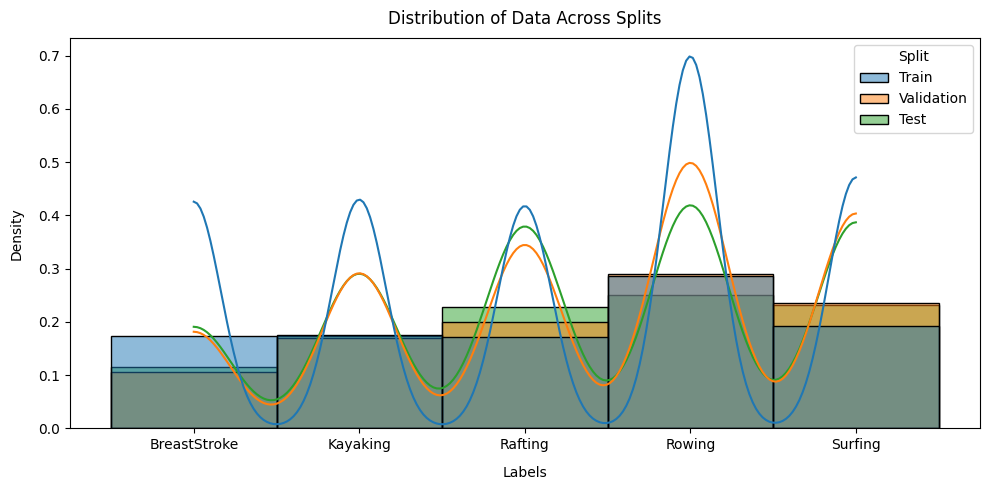

In [9]:
train_set["Split"]="Train"
validation_set["Split"]="Validation"
test_set["Split"]="Test"
combined_set=pd.concat(objs=[train_set, validation_set, test_set])
plt.figure(figsize=(10, 5))
sns.histplot(
    data=combined_set,
    x="label",
    hue="Split",
    stat="density",
    common_norm=False,
    kde=True,
    bins=20
)
plt.xlabel(
    xlabel="Labels",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.ylabel(
    ylabel="Density",
    labelpad=10,
    fontdict={"fontsize": 10}
)
plt.title(
    label="Distribution of Data Across Splits",
    pad=10,
    fontdict={"fontsize": 12}
)
plt.tight_layout()
plt.show()
train_set=train_set.drop(columns="Split")
validation_set=validation_set.drop(columns="Split")
test_set=test_set.drop(columns="Split")

In [ ]:
class VideoFrameDataset(Dataset):
    """
    A PyTorch Dataset class for loading sequences of video frames for training and evaluation.

    This dataset organizes video frames into input and target sequences, allowing models to learn frame-to-frame predictions.
    It handles the grouping of frames by video file and prepares samples consisting of input and target frame sequences.

    Arguments:
        dataframe (pd.DataFrame): A dataframe containing video file information and corresponding frame file paths.
        input_frames (int, optional): Number of frames to be used as input for each sample. Defaults to 10.
        target_frames (int, optional): Number of frames to be predicted as output for each sample. Defaults to 5.

    Attributes:
        dataframe (pd.DataFrame): The original dataframe containing video and frame information.
        input_frames (int): Number of input frames per sample.
        target_frames (int): Number of target frames per sample.
        samples (list): A list of tuples, each containing input and target frame sequences.
    """
    def __init__(self, dataframe, input_frames=10, target_frames=5):
        self.dataframe = dataframe
        self.input_frames = input_frames
        self.target_frames = target_frames
        self.samples = []

        video_groups = dataframe.groupby('video_file')

        for video_name, group in video_groups:
            frames = group.sort_values('frame_file')['prepared_frame'].tolist()
            num_frames = len(frames)
            total_frames = input_frames + target_frames

            for i in range(num_frames - total_frames + 1):
                input_sequence = frames[i:i+input_frames]
                target_sequence = frames[i+input_frames:i+total_frames]
                self.samples.append((input_sequence, target_sequence))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        input_sequence, target_sequence = self.samples[idx]

        input_frames = np.stack(input_sequence, axis=0)  # Shape: (input_frames, H, W, C)
        input_frames = np.transpose(input_frames, (0, 3, 1, 2))  # Shape: (input_frames, C, H, W)
        input_frames = input_frames.reshape(-1, input_frames.shape[2], input_frames.shape[3])  # Shape: (input_frames * C, H, W)

        target_frames = np.stack(target_sequence, axis=0)
        target_frames = np.transpose(target_frames, (0, 3, 1, 2))
        target_frames = target_frames.reshape(-1, target_frames.shape[2], target_frames.shape[3])

        input_frames = torch.FloatTensor(input_frames)
        target_frames = torch.FloatTensor(target_frames)

        return input_frames, target_frames


In [ ]:
INPUT_FRAMES = 10
TARGET_FRAMES = 5
BATCH_SIZE = 64

train_dataset = VideoFrameDataset(train_set, input_frames=INPUT_FRAMES, target_frames=TARGET_FRAMES)
val_dataset = VideoFrameDataset(validation_set, input_frames=INPUT_FRAMES, target_frames=TARGET_FRAMES)
test_dataset = VideoFrameDataset(test_set, input_frames=INPUT_FRAMES, target_frames=TARGET_FRAMES)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


In [ ]:
model = MaxViT(
    num_input_frames=INPUT_FRAMES,
    num_output_frames=TARGET_FRAMES,
    dim=64,
    depth=(2, 2, 2, 2),
    dim_head=32,
    channels_per_frame=3
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


In [20]:
model

MaxViT(
  (conv_stem): Sequential(
    (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate='none')
        (6): SqueezeExcitation(
          (gate): Sequential(
            (0): Reduce('b c h w -> b c', 'mean')
            (1): Linear(in_features=256, out_features=64, bias=False)
            (2): SiLU()
            (3): Linear(in_features=64, out_features=256, bias=False)
            (4): Sigmoid()
            (5): Re

In [ ]:
num_epochs = 50

In [30]:
import gc

def clear_gpu_memory():
    print("Clearing GPU memory...")
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.reset_accumulated_memory_stats()
    torch.cuda.synchronize()
    print("GPU memory cleared.")

os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

clear_gpu_memory()

Clearing GPU memory...
GPU memory cleared.


In [31]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")
    torch.save(model.state_dict(), "MaxViT_checkpoint.pth")



Epoch 1/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 1/50, Loss: 0.009342162952391465


Epoch 2/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 2/50, Loss: 0.008545251232557914


Epoch 3/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 3/50, Loss: 0.00806986335457711


Epoch 4/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 4/50, Loss: 0.0076898167649635


Epoch 5/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 5/50, Loss: 0.007404415414553196


Epoch 6/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 6/50, Loss: 0.007209273228881576


Epoch 7/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 7/50, Loss: 0.007018073805950825


Epoch 8/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 8/50, Loss: 0.006829251229779173


Epoch 9/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 9/50, Loss: 0.006735112662959305


Epoch 10/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 10/50, Loss: 0.006574595108312039


Epoch 11/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 11/50, Loss: 0.006470351063789589


Epoch 12/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 12/50, Loss: 0.0063171670375008196


Epoch 13/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 13/50, Loss: 0.006200913715610694


Epoch 14/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 14/50, Loss: 0.006108308165592848


Epoch 15/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 15/50, Loss: 0.005998873068446682


Epoch 16/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 16/50, Loss: 0.0059661225246230585


Epoch 17/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 17/50, Loss: 0.005788621011637366


Epoch 18/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 18/50, Loss: 0.0057361282253376245


Epoch 19/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 19/50, Loss: 0.005648266953189219


Epoch 20/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 20/50, Loss: 0.005552023795501532


Epoch 21/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 21/50, Loss: 0.005448802131693558


Epoch 22/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 22/50, Loss: 0.005368234007143548


Epoch 23/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 23/50, Loss: 0.005285933698934777


Epoch 24/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 24/50, Loss: 0.005209824451204967


Epoch 25/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 25/50, Loss: 0.005139473296335597


Epoch 26/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 26/50, Loss: 0.0050608177963156155


Epoch 27/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 27/50, Loss: 0.0049734877051142755


Epoch 28/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 28/50, Loss: 0.004922773214794937


Epoch 29/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 29/50, Loss: 0.004806204179894431


Epoch 30/50: 100%|██████████| 635/635 [07:24<00:00,  1.43it/s]


Epoch 30/50, Loss: 0.004765796916721399


Epoch 31/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 31/50, Loss: 0.0046555430986644965


Epoch 32/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 32/50, Loss: 0.004596387158240669


Epoch 33/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 33/50, Loss: 0.004526451475639662


Epoch 34/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 34/50, Loss: 0.00446128870443418


Epoch 35/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 35/50, Loss: 0.004365564705508667


Epoch 36/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 36/50, Loss: 0.004315033061327596


Epoch 37/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 37/50, Loss: 0.004265470743852328


Epoch 38/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 38/50, Loss: 0.004259705585603905


Epoch 39/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 39/50, Loss: 0.00416378696708701


Epoch 40/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 40/50, Loss: 0.004085612484514918


Epoch 41/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 41/50, Loss: 0.004043370793767123


Epoch 42/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 42/50, Loss: 0.003995195063266416


Epoch 43/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 43/50, Loss: 0.003944739294807711


Epoch 44/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 44/50, Loss: 0.003908831363447017


Epoch 45/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 45/50, Loss: 0.003851814528256677


Epoch 46/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 46/50, Loss: 0.0038425883282859384


Epoch 47/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 47/50, Loss: 0.0038228117856565986


Epoch 48/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 48/50, Loss: 0.0037184106640252104


Epoch 49/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 49/50, Loss: 0.0036547968124052634


Epoch 50/50: 100%|██████████| 635/635 [07:23<00:00,  1.43it/s]


Epoch 50/50, Loss: 0.0036172893295356497


In [ ]:
def compute_metrics(outputs, targets):
    """
    Computes Mean Squared Error (MSE) and Structural Similarity Index Measure (SSIM) between outputs and targets.

    This function calculates the MSE and SSIM for each frame in the batch and returns the average metrics.

    Arguments:
        outputs (torch.Tensor): The predicted frames from the model. Shape: (batch_size, total_channels, height, width)
        targets (torch.Tensor): The ground truth frames. Shape: (batch_size, total_channels, height, width)

    Returns:
        tuple: A tuple containing the mean MSE and mean SSIM across all frames and batches.
    """
    outputs = outputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()

    batch_size, total_channels, height, width = outputs.shape
    num_frames = TARGET_FRAMES
    channels_per_frame = total_channels // num_frames
    outputs = outputs.reshape(batch_size, num_frames, channels_per_frame, height, width)
    targets = targets.reshape(batch_size, num_frames, channels_per_frame, height, width)

    mse_list = []
    ssim_list = []
    for b in range(batch_size):
        for f in range(num_frames):
            output_frame = outputs[b, f].transpose(1, 2, 0)  
            target_frame = targets[b, f].transpose(1, 2, 0)

            #print(f"Output frame shape: {output_frame.shape}")

            mse_frame = np.mean((output_frame - target_frame) ** 2)

            min_dim = min(output_frame.shape[0], output_frame.shape[1])
            win_size = min(7, min_dim)
            if win_size % 2 == 0:
                win_size -= 1  

            if win_size < 3:
                win_size = 3 

            ssim_frame = ssim(
                output_frame,
                target_frame,
                channel_axis=-1,
                win_size=win_size,
                data_range=1.0 
            )

            mse_list.append(mse_frame)
            ssim_list.append(ssim_frame)
    mean_mse = np.mean(mse_list)
    mean_ssim = np.mean(ssim_list)
    return mean_mse, mean_ssim


In [ ]:
model.eval()
test_loss = 0.0
mse_total = 0.0
ssim_total = 0.0
count = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)

        mse_value, ssim_value = compute_metrics(outputs, targets)
        mse_total += mse_value * inputs.size(0)
        ssim_total += ssim_value * inputs.size(0)
        count += inputs.size(0)
test_loss = test_loss / len(test_dataset)
mean_mse = mse_total / count
mean_ssim = ssim_total / count
print(f"Test Loss: {test_loss}, MSE: {mean_mse}, SSIM: {mean_ssim}")


Test Loss: 0.004899398203795919, MSE: 0.004899397992866707, SSIM: 0.7783712547690004


In [ ]:
def save_video_clip(frames, output_path, fps=10):
    """
    Saves a list of frames as a video file.

    This function takes a list of frames, converts them to the appropriate format, and writes them to a video file at the specified `output_path`.

    Arguments:
        frames (list): A list of frames (as NumPy arrays) to be saved as a video.
        output_path (str): The path where the output video will be saved.
        fps (int, optional): Frames per second for the output video. Defaults to 10.
    """
    height, width, channels = frames[0].shape
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for frame in frames:
        frame = (frame * 255).astype(np.uint8)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame)
    out.release()


In [ ]:
def generate_frames(
    model: nn.Module,
    data_loader: DataLoader,
    device: torch.device
) -> np.ndarray:
    """
    Generates frames using the trained model and a data loader.

    This function iterates over the `data_loader`, processes each batch through the `model`, and collects the generated frames.

    Arguments:
        model (nn.Module): The trained video generation model.
        data_loader (DataLoader): DataLoader providing input batches for frame generation.
        device (torch.device): The device (CPU or GPU) to perform computations on.

    Returns:
        np.ndarray: An array of generated frames.
    """
    model.eval()
    generated_frames = []
    with torch.no_grad():
        for input_frames, _ in tqdm(
            iterable=data_loader,
            desc="Generating Frames",
            unit="batch"
        ):
            input_frames = input_frames.to(device)  
            outputs = model(input_frames)           
            outputs = outputs.cpu().numpy()
            batch_size, total_channels, height, width = outputs.shape
            num_frames = TARGET_FRAMES
            channels_per_frame = total_channels // num_frames
            outputs = outputs.reshape(batch_size, num_frames, channels_per_frame, height, width)
            generated_frames.append(outputs)
    generated_frames = np.concatenate(generated_frames, axis=0) 
    return generated_frames


In [ ]:
generated_frames = generate_frames(
    model=model,
    data_loader=test_loader,
    device=device
)

N, num_frames, channels_per_frame, height, width = generated_frames.shape
video_frames = generated_frames.reshape(-1, channels_per_frame, height, width)  

video_frames = [frame.transpose(1, 2, 0) for frame in video_frames] 

Generating Frames: 100%|██████████| 72/72 [00:17<00:00,  4.08batch/s]


In [ ]:
def create_video(
    frames: list,
    video_path: str,
    fps: int=10
):
    """
    Creates a video file from a list of frames.

    This function takes a list of frames, converts them to the appropriate format, and writes them to a video file at the specified `video_path`.

    Arguments:
        frames (list): A list of frames (as NumPy arrays) to be compiled into a video.
        video_path (str): The path where the output video will be saved.
        fps (int, optional): Frames per second for the output video. Defaults to 10.
    """
    frame_shape = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        filename=video_path,
        fourcc=fourcc,
        fps=fps,
        frameSize=(frame_shape[1], frame_shape[0]),
        isColor=True
    )
    for frame in tqdm(
        iterable=frames,
        desc="Creating Video",
        unit="frame"
    ):
        frame = (frame * 255).astype(np.uint8)
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)) 
    out.release()


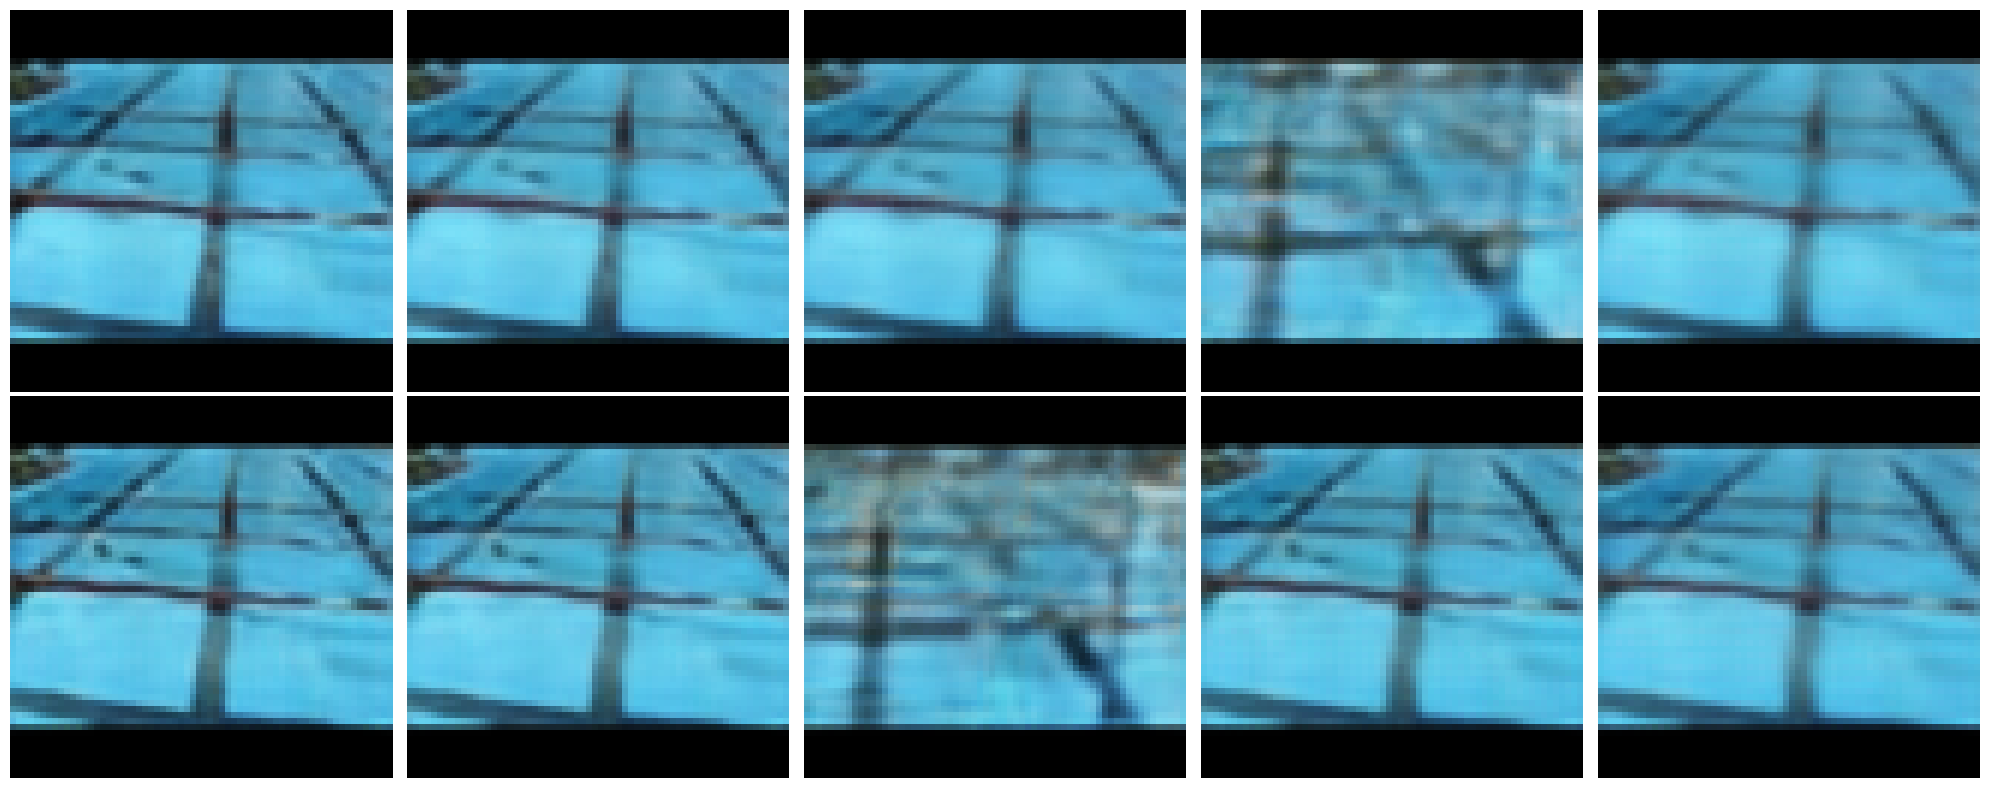

In [ ]:
_, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(20, 8)
)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_frames[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [50]:
video_path = "app/out/results/generated_video_MaxViT.mp4"
create_video(
    frames=video_frames,
    video_path=video_path,
    fps=20
)


Creating Video: 100%|██████████| 22750/22750 [00:02<00:00, 8587.96frame/s]


In [51]:
torch.save(model.state_dict(), 'MaxViT.pth')

In [52]:
model = MaxViT(
    num_input_frames=INPUT_FRAMES,
    num_output_frames=TARGET_FRAMES,
    dim=64,
    depth=(2, 2, 2, 2),
    dim_head=32,
    channels_per_frame=3
)
model.load_state_dict(torch.load('MaxViT.pth', map_location=device))
model.eval()

<ipython-input-52-0207b7c7a5d3>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('MaxViT.pth', map_location=device))


MaxViT(
  (conv_stem): Sequential(
    (0): Conv2d(30, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=256)
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate='none')
        (6): SqueezeExcitation(
          (gate): Sequential(
            (0): Reduce('b c h w -> b c', 'mean')
            (1): Linear(in_features=256, out_features=64, bias=False)
            (2): SiLU()
            (3): Linear(in_features=64, out_features=256, bias=False)
            (4): Sigmoid()
            (5): Re

In [55]:
model = model.to(device)

In [ ]:
generated_frames = generate_frames(
    model=model,
    data_loader=test_loader,
    device=device
)

N, num_frames, channels_per_frame, height, width = generated_frames.shape
video_frames = generated_frames.reshape(-1, channels_per_frame, height, width)  

video_frames = [frame.transpose(1, 2, 0) for frame in video_frames] 

Generating Frames: 100%|██████████| 72/72 [00:18<00:00,  3.99batch/s]


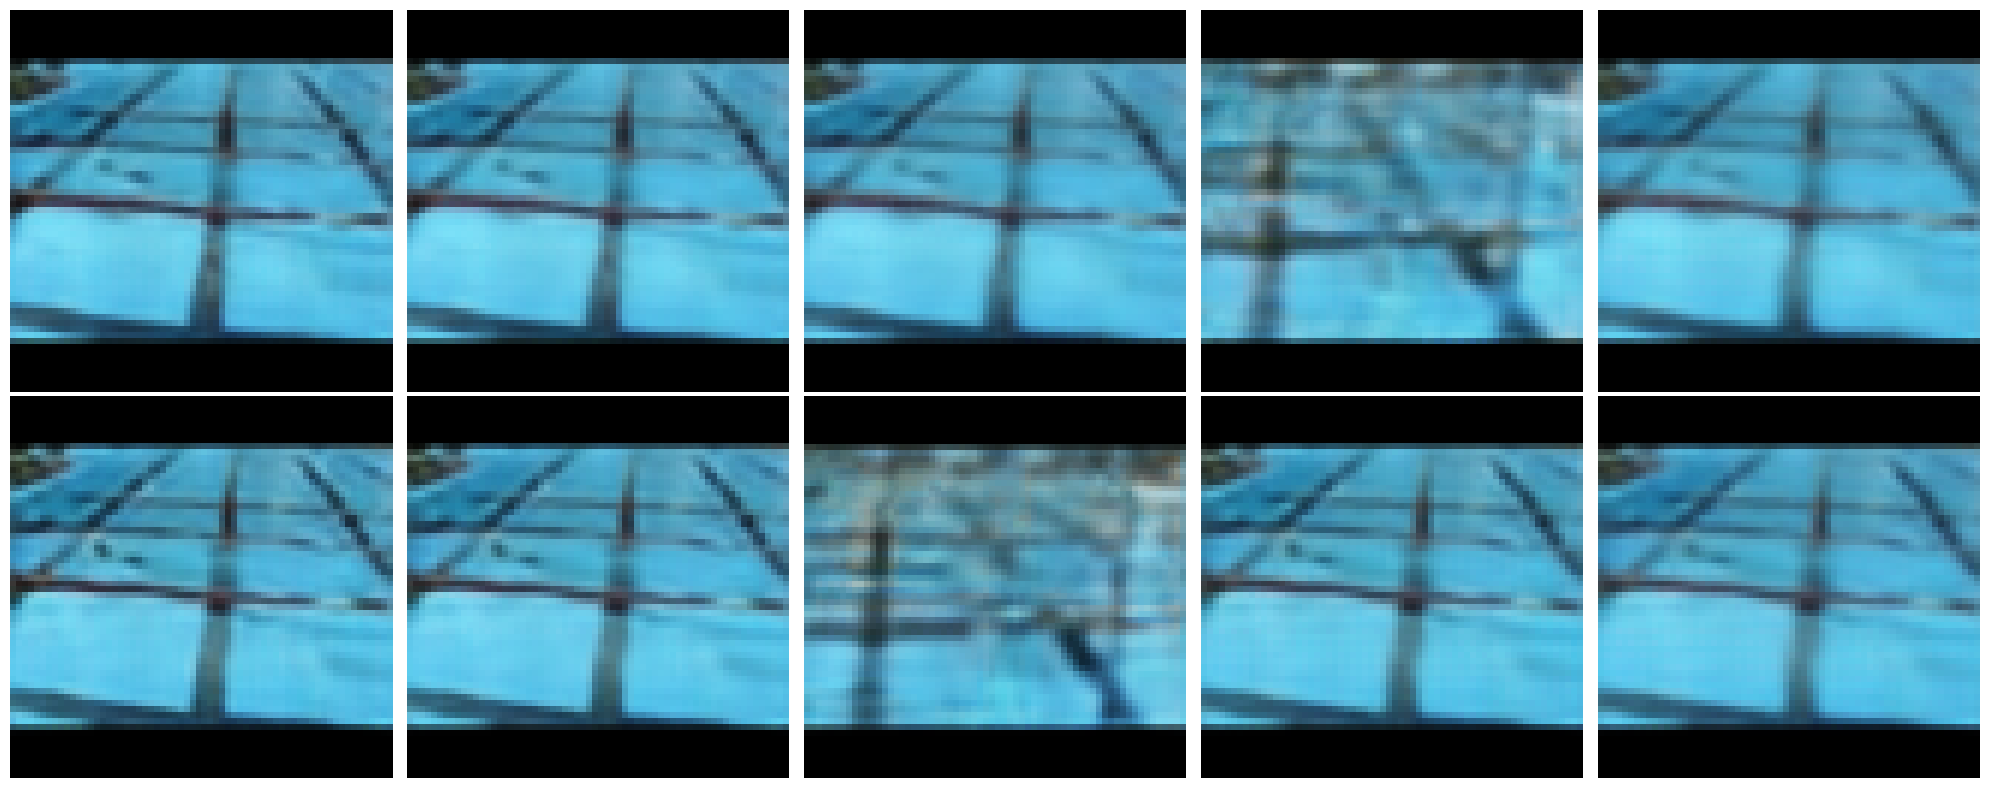

In [ ]:
_, axes = plt.subplots(
    nrows=2,
    ncols=5,
    figsize=(20, 8)
)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(video_frames[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp MaxViT.pth /content/drive/MyDrive/

Mounted at /content/drive
